In [1]:
import pandas as pd
import numpy as np
import os
import pathlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
cwd = os.getcwd()
cwd

'/mnt/EC86AD3086ACFC68/unal/tny/data'

In [3]:
def load_data(csv):
    return pd.read_csv(csv, index_col=0)

In [4]:
def save_list_2_csv(list_, name, path):
    "list_: list to save; name: file name"
    pd.DataFrame({name:list(list_)}).to_csv(os.path.join(path, name+'.csv'))
    print("--- List was saved as: "+name+".csv")

In [5]:
def time_elements2int(array_):
    for list_ in array_:
        for ii in range(len(list_)):
            if list_[ii] == '00':
                list_[ii] = 0
            elif list_[ii][0] == '0':
                list_[ii] = int(list_[ii][1])
            else:
                list_[ii] = int(list_[ii])
    return array_

In [6]:
def date_elements2int(list_):
    for date in list_:
        date[0] = int(date[0])
        if date[1].startswith("0"):
            date[1] = int(date[1][1])
        else:
            date[1] = int(date[1])
        if date[2].startswith("0"):
            date[2] = int(date[2][1])
        else:
            date[2] = int(date[2])
    return list_

In [7]:
def total_times(do_hour, do_min, do_sec, pu_hour, pu_min, pu_sec):
    assert len(pu_min) == len(do_min)
    range_ = len(pu_min)
    total_times_list = []
    for ii in range(range_):
        hour_diff = do_hour[ii] - pu_hour[ii]
        mins_diff = do_min[ii] - pu_min[ii]
        secs_diff = do_sec[ii] - pu_sec[ii]
        if hour_diff < 0:
            hour_diff = 24+hour_diff  
        if mins_diff < 0:
            mins_diff = 60+mins_diff
        if secs_diff < 0:
            secs_diff = 60+secs_diff    
        total_time = hour_diff*60*60 + mins_diff*60 + secs_diff
        total_times_list.append(total_time)
    return total_times_list

# LOAD

In [8]:
base = load_data("yellow_tripdata_2019-03.csv")
base.columns

/home/santiago/anaconda3/envs/tny/lib/python3.7/site-packages/numpy/lib/arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Index(['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count',
       'trip_distance', 'RatecodeID', 'store_and_fwd_flag', 'PULocationID',
       'DOLocationID', 'payment_type', 'fare_amount', 'extra', 'mta_tax',
       'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount',
       'congestion_surcharge'],
      dtype='object')

# PROCESS

In [9]:
base = base[['tpep_pickup_datetime', 'tpep_dropoff_datetime',
             'trip_distance', 'fare_amount', 'total_amount', 'RatecodeID']]

# datetime -> date, time
base[["pu_date", "pu_time"]] = base["tpep_pickup_datetime"].str.split(" ", expand=True)
base[["do_date", "do_time"]] = base["tpep_dropoff_datetime"].str.split(" ", expand=True)
base = base[['pu_date', 'pu_time', 'do_date', 'do_time', 'trip_distance', 
             'total_amount', 'RatecodeID']]

# date -> year, month, day
base[["pu_year", "pu_month", "pu_day"]] = base["pu_date"].str.split("-", expand=True)
base[["do_year", "do_month", "do_day"]] = base["do_date"].str.split("-", expand=True)
base = base[['pu_year', 'pu_month', 'pu_day', 'pu_time', 'do_year', 'do_month', 
             'do_day', 'do_time','trip_distance', 'total_amount', 'RatecodeID']]

# time -> hour, min, sec
base[['pu_hour', 'pu_min', 'pu_sec']] = base['pu_time'].str.split(":", expand=True)
base[['do_hour', 'do_min', 'do_sec']] = base['do_time'].str.split(":", expand=True)
base = base[['pu_year', 'pu_month', 'pu_day', 'do_year', 'do_month',
             'do_day', 'trip_distance', 'total_amount', 'pu_hour',
             'pu_min', 'pu_sec', 'do_hour', 'do_min', 'do_sec', 'RatecodeID']]

base.columns

Index(['pu_year', 'pu_month', 'pu_day', 'do_year', 'do_month', 'do_day',
       'trip_distance', 'total_amount', 'pu_hour', 'pu_min', 'pu_sec',
       'do_hour', 'do_min', 'do_sec', 'RatecodeID'],
      dtype='object')

In [10]:
# times str to int

times = {'pu_hour':list(base.pu_hour), 'pu_min':list(base.pu_min), 
         'pu_sec':list(base.pu_sec), 'do_hour':list(base.do_hour), 
         'do_min':list(base.do_min), 'do_sec':list(base.do_sec)}

for ii in range(len(base)):
    # pu
    if times["pu_hour"][ii][0]=="0":
        times["pu_hour"][ii] = int(times["pu_hour"][ii][1])
    else:
        times["pu_hour"][ii] = int(times["pu_hour"][ii])
    
    if times["pu_min"][ii][0]=="0":
        times["pu_min"][ii] = int(times["pu_min"][ii][1])
    else:
        times["pu_min"][ii] = int(times["pu_min"][ii])
    
    if times["pu_sec"][ii][0]=="0":
        times["pu_sec"][ii] = int(times["pu_sec"][ii][1])
    else:
        times["pu_sec"][ii] = int(times["pu_sec"][ii])
        
    # do
    if times["do_hour"][ii][0]=="0":
        times["do_hour"][ii] = int(times["do_hour"][ii][1])
    else:
        times["do_hour"][ii] = int(times["do_hour"][ii])
    
    if times["do_min"][ii][0]=="0":
        times["do_min"][ii] = int(times["do_min"][ii][1])
    else:
        times["do_min"][ii] = int(times["do_min"][ii])
    
    if times["do_sec"][ii][0]=="0":
        times["do_sec"][ii] = int(times["do_sec"][ii][1])
    else:
        times["do_sec"][ii] = int(times["do_sec"][ii])
        
drop_list = ['pu_hour', 'pu_min', 'pu_sec', 'do_hour', 
                         'do_min', 'do_sec']

base = base.drop(columns=drop_list)

for col in drop_list:
    base[col] = times[col]

base.columns

Index(['pu_year', 'pu_month', 'pu_day', 'do_year', 'do_month', 'do_day',
       'trip_distance', 'total_amount', 'RatecodeID', 'pu_hour', 'pu_min',
       'pu_sec', 'do_hour', 'do_min', 'do_sec'],
      dtype='object')

In [11]:
trip_times = total_times(list(base["do_hour"]), list(base["do_min"]), 
                         list(base["do_sec"]), list(base["pu_hour"]), 
                         list(base["pu_min"]), list(base["pu_sec"]))

base["trip_time(s)"] = trip_times

base.columns

Index(['pu_year', 'pu_month', 'pu_day', 'do_year', 'do_month', 'do_day',
       'trip_distance', 'total_amount', 'RatecodeID', 'pu_hour', 'pu_min',
       'pu_sec', 'do_hour', 'do_min', 'do_sec', 'trip_time(s)'],
      dtype='object')

# CLEANING

In [12]:
base = base[(base.trip_distance<201) & (base.trip_distance>0.05)]
base = base[(base.total_amount<650) & (base.total_amount>0.5)]
base = base[(base.pu_year=="2019") & (base.do_year=="2019")]
base = base[(base.pu_month=="03") & (base.do_month=="03")]

In [13]:
base.sort_values(by=["trip_distance"], ascending=False).head()

,pu_year,pu_month,pu_day,do_year,do_month,do_day,trip_distance,total_amount,RatecodeID,pu_hour,pu_min,pu_sec,do_hour,do_min,do_sec,trip_time(s)
VendorID,,,,,,,,,,,,,,,,
1,2019,03,02,2019,03,03,200.90,471.30,5,22,3,47,1,0,3,14236
1,2019,03,24,2019,03,24,150.90,450.00,5,15,8,54,17,51,57,9783
2,2019,03,22,2019,03,22,142.98,300.86,5,11,42,12,14,16,34,12862
2,2019,03,24,2019,03,24,139.44,368.82,1,10,38,38,13,30,49,13931
2,2019,03,16,2019,03,16,131.51,256.06,5,15,37,39,18,26,5,13766


In [14]:
base.sort_values(by=["trip_distance"], ascending=False).tail()

,pu_year,pu_month,pu_day,do_year,do_month,do_day,trip_distance,total_amount,RatecodeID,pu_hour,pu_min,pu_sec,do_hour,do_min,do_sec,trip_time(s)
VendorID,,,,,,,,,,,,,,,,
2,2019,03,10,2019,03,10,0.06,6.3,1,21,4,9,21,4,37,28
2,2019,03,07,2019,03,07,0.06,4.3,1,16,54,47,16,55,29,102
2,2019,03,30,2019,03,30,0.06,3.3,1,8,40,38,8,40,51,13
2,2019,03,08,2019,03,08,0.06,4.3,1,18,42,10,18,42,43,33
2,2019,03,17,2019,03,17,0.06,6.3,1,14,11,25,14,12,49,84


# FILTERING

## BY DAY

In [15]:
fridays = ['01', '08', '15', '22', '29']
saturdays = ['02', '09', '16', '23', '30']
sundays = ['03', '10', '17', '24', '31']
mondays = ['04', '11', '18', '25']
tuesdays = ['05', '12', '19', '26']
wednesdays = ['06', '13', '20', '27']
thursdays = ['07', '14', '21', '28']

In [16]:
monday = base[(base.pu_day==mondays[0])]
tuesday = base[(base.pu_day==tuesdays[0])]
wednesday = base[(base.pu_day==wednesdays[0])]
thursday = base[(base.pu_day==thursdays[0])]
friday = base[(base.pu_day==fridays[0])]
saturday = base[(base.pu_day==saturdays[0])]
sunday = base[(base.pu_day==sundays[0])]

days_list = [friday, saturday, sunday, monday, tuesday, wednesday, thursday]

In [17]:
days_names_list = ['friday', 'saturday', 'sunday', 'monday', 'tuesday', 'wednesday', 'thursday']

In [18]:
del base

In [19]:
monday.head()

,pu_year,pu_month,pu_day,do_year,do_month,do_day,trip_distance,total_amount,RatecodeID,pu_hour,pu_min,pu_sec,do_hour,do_min,do_sec,trip_time(s)
VendorID,,,,,,,,,,,,,,,,
2,2019,03,04,2019,03,04,8.59,40.27,1,5,33,57,5,50,56,1079
2,2019,03,04,2019,03,04,0.93,6.80,1,6,4,56,6,8,27,271
2,2019,03,04,2019,03,04,9.23,43.82,1,6,24,47,6,42,52,1085
2,2019,03,04,2019,03,04,1.22,12.25,1,7,22,10,7,28,58,408
2,2019,03,04,2019,03,04,9.27,40.06,1,7,33,54,7,55,1,1327


### SAVING

#### DISTANCES BY DAY

In [20]:
dist_dir = cwd+"/output/distances/"
pathlib.Path(cwd+dist_dir).mkdir(parents=True, exist_ok=True)

In [21]:
m_distances = list(monday.trip_distance)
save_list_2_csv(m_distances, "monday_distances", dist_dir)

--- List was saved as: monday_distances.csv


In [22]:
tu_distances = list(tuesday.trip_distance)
save_list_2_csv(tu_distances, "tuesday_distances", dist_dir)

--- List was saved as: tuesday_distances.csv


In [23]:
we_distances = list(wednesday.trip_distance)
save_list_2_csv(we_distances, "wednesday_distances", dist_dir)

--- List was saved as: wednesday_distances.csv


In [24]:
th_distances = list(thursday.trip_distance)
save_list_2_csv(th_distances, "thursday_distances", dist_dir)

--- List was saved as: thursday_distances.csv


In [25]:
fr_distances = list(friday.trip_distance)
save_list_2_csv(fr_distances, "friday_distances", dist_dir)

--- List was saved as: friday_distances.csv


In [26]:
sa_distances = list(saturday.trip_distance)
save_list_2_csv(sa_distances, "saturday_distances", dist_dir)

--- List was saved as: saturday_distances.csv


In [27]:
su_distances = list(sunday.trip_distance)
save_list_2_csv(su_distances, "sunday_distances", dist_dir)

--- List was saved as: sunday_distances.csv


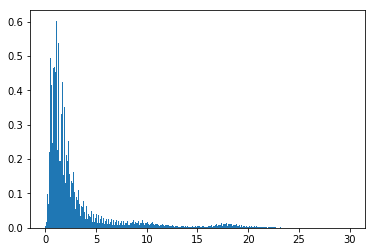

In [28]:
plt.hist(m_distances, bins=300, range=(0,30), density=True)
plt.show()

#### MONEY BY DAY

In [29]:
money_dir = cwd+"/output/money/"
pathlib.Path(money_dir).mkdir(parents=True, exist_ok=True)

In [30]:
m_fares = list(monday.total_amount)
save_list_2_csv(m_fares, "monday_fares", money_dir)

--- List was saved as: monday_fares.csv


In [31]:
tu_fares = list(tuesday.total_amount)
save_list_2_csv(tu_fares, "tuesday_fares", money_dir)

--- List was saved as: tuesday_fares.csv


In [32]:
we_fares = list(wednesday.total_amount)
save_list_2_csv(we_fares, "wednesday_fares", money_dir)

--- List was saved as: wednesday_fares.csv


In [33]:
th_fares = list(thursday.total_amount)
save_list_2_csv(th_fares, "thursday_fares", money_dir)

--- List was saved as: thursday_fares.csv


In [34]:
fr_fares = list(friday.total_amount)
save_list_2_csv(fr_fares, "friday_fares", money_dir)

--- List was saved as: friday_fares.csv


In [35]:
sa_fares = list(saturday.total_amount)
save_list_2_csv(sa_fares, "saturday_fares", money_dir)

--- List was saved as: saturday_fares.csv


In [36]:
su_fares = list(sunday.total_amount)
save_list_2_csv(su_fares, "sunday_fares", money_dir)

--- List was saved as: sunday_fares.csv


<function matplotlib.pyplot.show(*args, **kw)>

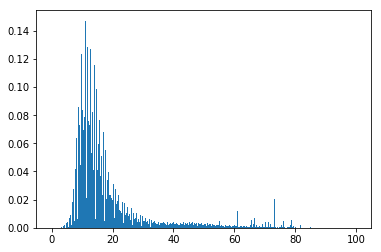

In [37]:
plt.hist(m_fares, bins=300, range=(0,100), density=True)
plt.show

## BY TIME OF DAY

In [21]:
monday.head()

,pu_year,pu_month,pu_day,do_year,do_month,do_day,trip_distance,total_amount,RatecodeID,pu_hour,pu_min,pu_sec,do_hour,do_min,do_sec,trip_time(s)
VendorID,,,,,,,,,,,,,,,,
2,2019,03,04,2019,03,04,8.59,40.27,1,5,33,57,5,50,56,1079
2,2019,03,04,2019,03,04,0.93,6.80,1,6,4,56,6,8,27,271
2,2019,03,04,2019,03,04,9.23,43.82,1,6,24,47,6,42,52,1085
2,2019,03,04,2019,03,04,1.22,12.25,1,7,22,10,7,28,58,408
2,2019,03,04,2019,03,04,9.27,40.06,1,7,33,54,7,55,1,1327


In [28]:
var = "money"
for day, day_name in zip(days_list, days_names_list):
    day_dir = cwd+"/output/"+var+"/"+day_name
    day_dir_f = cwd+"/output/"+var+"_filtered/"+day_name
    pathlib.Path(day_dir).mkdir(parents=True, exist_ok=True)
    pathlib.Path(day_dir_f).mkdir(parents=True, exist_ok=True)
    for hour in range(24):
        day_ = day.copy()
        day_hour = day_[(day_.pu_hour==hour)]
        day_hour_list = list(day_hour["trip_time(s)"])
        save_list_2_csv(day_hour_list, str(hour)+"_"+var, day_dir)
        
        day_f = day.copy()
        day_f = day_f[day_f.RatecodeID==1]
        day_hour_f = day_f[(day_f.pu_hour==hour)]
        day_hour_f_list = list(day_hour_f["trip_time(s)"])
        save_list_2_csv(day_hour_f_list, str(hour)+"_"+var , day_dir_f)

--- List was saved as: 0_money.csv
--- List was saved as: 0_money.csv
--- List was saved as: 1_money.csv
--- List was saved as: 1_money.csv
--- List was saved as: 2_money.csv
--- List was saved as: 2_money.csv
--- List was saved as: 3_money.csv
--- List was saved as: 3_money.csv
--- List was saved as: 4_money.csv
--- List was saved as: 4_money.csv
--- List was saved as: 5_money.csv
--- List was saved as: 5_money.csv
--- List was saved as: 6_money.csv
--- List was saved as: 6_money.csv
--- List was saved as: 7_money.csv
--- List was saved as: 7_money.csv
--- List was saved as: 8_money.csv
--- List was saved as: 8_money.csv
--- List was saved as: 9_money.csv
--- List was saved as: 9_money.csv
--- List was saved as: 10_money.csv
--- List was saved as: 10_money.csv
--- List was saved as: 11_money.csv
--- List was saved as: 11_money.csv
--- List was saved as: 12_money.csv
--- List was saved as: 12_money.csv
--- List was saved as: 13_money.csv
--- List was saved as: 13_money.csv
--- List was